# Create 3D SVR dicom

Converts 3D nifti file into single-frame dicom files

INPUT:
- 3D SVR .nii file
- 2D dicom from scanner

OUTPUT:
- 3D SVR dicom

In [34]:
dcmInPath = r'C:\Users\tr17\Dropbox\PrideSVR\Untouched_Dicoms_Exported_from_Simulator\DICOM\IM_0001'
# niiInPath = r'C:\Users\tr17\Dropbox\PrideSVR\pride_export_complete\SVR-output-brain.nii.gz' 
niiInPath = r'C:\Users\tr17\Dropbox\PrideSVR\pride_export_complete\SVR-output-brain-pad160.nii.gz' # mirtk pad-3d SVR-output-brain.nii.gz SVR-output-brain_padtest.nii.gz 160 160 160
dcmOutPath = r'C:\Users\tr17\Dropbox\TempOutputSeries_2021_01_11\DICOM'

if not os.path.exists( dcmOutPath ):
    os.makedirs( dcmOutPath )

In [35]:
import os
import subprocess
import datetime, time
import numpy as np
import numpy.matlib
import nibabel as nib
import matplotlib
import matplotlib.pyplot as plt
import pydicom as pyd
from pydicom.dataset import Dataset, FileDataset, FileMetaDataset
from pydicom.datadict import DicomDictionary, keyword_dict
from pydicom.sequence import Sequence

In [36]:
# define non-standard Private Tags to be created

# Define items as (VR, VM, description, is_retired flag, keyword)
# - leave is_retired flag blank.
new_dict_items = {
    0x20011002: ('IS', '1', "Chemical Shift Number MR", '', 'ChemicalShiftNumberMR'),
    0x20011008: ('IS', '1', "Phase Number", '', 'PhaseNumber'),
    0x2001100a: ('IS', '1', "Slice Number MR", '', 'SliceNumberMR'),
    0x2001100b: ('CS', '1', "Slice Orientation", '', 'SliceOrientation'),
    0x20011014: ('SL', '1', "Number Of Echoes", '', 'NumberOfEchoes'),
    0x20011015: ('SS', '1', "Number Of Locations", '', 'NumberOfLocations'),
    0x20011016: ('SS', '1', "Number Of PC Directions", '', 'NumberOfPCDirections'),
    0x20011017: ('SL', '1', "Number Of Phases MR", '', 'NumberOfPhasesMR'),
    0x20011018: ('SL', '1', "Number Of Slices MR", '', 'NumberOfSlicesMR'),
    0x20011020: ('LO', '1', "Scanning Technique", '', 'ScanningTechnique'),
    0x20011025: ('SH', '1', "Echo Time Display MR", '', 'EchoTimeDisplayMR'),
    0x20011060: ('SL', '1', "Number Of Stacks", '', 'NumberOfStacks'),
    0x20011063: ('CS', '1', "Examination Source", '', 'ExaminationSource'),
    0x2001107b: ('IS', '1', "Acquisition Number", '', 'AcquisitionNumber'),
    0x20011081: ('IS', '1', "Number Of Dynamic Scans", '', 'NumberOfDynamicScans'),
    0x2001101a: ('FL', '3', "PC Velocity", '', 'PCVelocity'),
    0x2001101d: ('IS', '1', "Reconstruction Number MR", '', 'ReconstructionNumberMR'),
    0x20051035: ('CS', '1', '', '', 'unknowntag20051035'), # PIXEL --- this seems to also correspond to MRSeriesDataType?
    
    # Philips "Stack" Tags
    0x2001105f: ('SQ', '1','Stack','','Stack'),
    0x20010010: ('LO', '1', "Private Creator", '', 'PrivateCreator20010010'),
    0x2001102d: ('SS', '1','StackNumberOfSlices','','StackNumberOfSlices'),
    0x20011032: ('FL', '1','StackRadialAngle','','StackRadialAngle'),
    0x20011033: ('CS', '1','StackRadialAxis','','StackRadialAxis'),
    0x20011035: ('FL', '1','MRSeriesDataType','','MRSeriesDataType'), # SS - StackSliceNumber ?
    0x20011036: ('CS', '1','StackType','','StackType'),
    0x20050010: ('LO', '1', 'Private Creator', '', 'PrivateCreator20050010'), # Is this duplicate necessary with entry above?
    0x20050011: ('LO', '1', 'Private Creator', '', 'PrivateCreator20050011'),
    0x20050012: ('LO', '1', 'Private Creator', '', 'PrivateCreator20050012'),    
    0x20050013: ('LO', '1', 'Private Creator', '', 'PrivateCreator20050013'),
    0x20050014: ('LO', '1', 'Private Creator', '', 'PrivateCreator20050014'),
    0x20050015: ('LO', '1', 'Private Creator', '', 'PrivateCreator20050015'),
    0x20051071: ('FL', '1','MRStackAngulationAP','','MRStackAngulationAP'),
    0x20051072: ('FL', '1','MRStackAngulationFH','','MRStackAngulationFH'),
    0x20051073: ('FL', '1','MRStackAngulationRL','','MRStackAngulationRL'),
    0x20051074: ('FL', '1','MRStackFovAP','','MRStackFovAP'),
    0x20051075: ('FL', '1','MRStackFovFH','','MRStackFovFH'),
    0x20051076: ('FL', '1','MRStackFovRL','','MRStackFovRL'),
    0x20051078: ('FL', '1','MRStackOffcentreAP','','MRStackOffcentreAP'),
    0x20051079: ('FL', '1','MRStackOffcentreFH','','MRStackOffcentreFH'),
    0x2005107a: ('FL', '1','MRStackOffcentreRL','','MRStackOffcentreRL'),
    0x2005107b: ('CS', '1','MRStackPreparationDirection','','MRStackPreparationDirection'),
    0x2005107e: ('FL', '1','MRStackSliceDistance','','MRStackSliceDistance'),
    0x20051081: ('CS', '1','MRStackViewAxis','','MRStackViewAxis'),
    0x2005143c: ('FL', '1','MRStackTablePosLong','','MRStackTablePosLong'),
    0x2005143d: ('FL', '1','MRStackTablePosLat','','MRStackTablePosLat'),
    0x2005143e: ('FL', '1','MRStackPosteriorCoilPos','','MRStackPosteriorCoilPos'),
    0x20051567: ('IS', '1','MRPhilipsX1','','MRPhilipsX1'),         

    # Phase Contrast/Velocity Tags
    0x00089209: ('CS', '1', "Acquisition Contrast", '', 'AcquisitionContrast'),
    0x00189014: ('CS', '1', "Phase Contrast", '', 'PhaseContrast'),
    0x00189090: ('FD', '3', "Velocity Encoding Direction", '', 'VelocityEncodingDirection'),
    0x00189091: ('FD', '1', "Velocity Encoding Minimum Value", '', 'VelocityEncodingMinimumValue'),
}

# Update the dictionary itself
DicomDictionary.update(new_dict_items)

# Update the reverse mapping from name to tag
new_names_dict = dict([(val[4], tag) for tag, val in new_dict_items.items()])
keyword_dict.update(new_names_dict)

In [37]:
dcmIn = pyd.dcmread(dcmInPath)

niiIn   = nib.load(niiInPath)
nii_img = niiIn.get_fdata()

# set background pixels = 0 (-1 in SVRTK)
iBkrd = nii_img==-1; nii_img[iBkrd] = 0

# match DICOM datatype
nii_img = nii_img.astype("uint16")

In [38]:
dt = datetime.datetime.now()
today_date = dt.strftime('%Y%m%d')
today_time = dt.strftime('%H%M%S.%f')

print('today_date =', today_date)
print('today_time =', today_time)

today_date = 20210111
today_time = 144827.046440


In [39]:
def get_nii_parameters(niiIn):
    
    """
    Get parameters from nifti to transfer to dicom
    - INPUT: 
    niiIn --- nii loaded with nibabel
    iInstance --- instance number, i.e.: slice number/frame number

    - OUTPUT:
    nii_parameters --- parameters to transfer to dicom header

    """

    nii_img = niiIn.get_fdata()

    if niiIn.header['dim'][4] == 1:
        nX, nY, nZ, nF   = niiIn.header['dim'][1], niiIn.header['dim'][2], niiIn.header['dim'][3], 1
        dimX, dimY, dimZ = niiIn.header['pixdim'][1], niiIn.header['pixdim'][2], niiIn.header['pixdim'][3]

    elif niiIn.header['dim'][4] > 1:
        print("Warning: Nifti is not 3-D ...")

    # number of instances
    nInstances = nZ*nF

    # slice location arrays
    sliceIndices = np.repeat(range(1, nZ+1), nF)

    # slice locations array
    voxelSpacing = dimZ
    zLocLast = (voxelSpacing * nZ) - voxelSpacing
    sliceLoca = np.repeat( np.linspace(0, zLocLast, num=nZ), nF)

    # TODO: windowing
    # windowCenter = []
    # windowWidth = []
    # rescaleIntercept = []
    # rescaleSlope = []

    # nii parameters to transfer to dicom
    nii_parameters = {
        'SliceThickness': str(dimZ),
        'SpacingBetweenSlices': str(dimZ),
        'AcquisitionMatrix': [0, nX, nY, 0],
        'InstanceNumber': sliceIndices,
        'SliceLocation': sliceLoca,
        'Rows': nX,
        'Columns': nY,
        'NumberOfSlices': nZ,
        'PixelSpacing': [dimX, dimY],
        'WindowCenter': str(1000),
        'WindowWidth': str(1800),
        'RescaleIntercept': str(0),
        'RescaleSlope': str(21),
    }

    return nii_parameters

In [40]:
def elem_initialise(uid_instance, uid_series_instance, uid_frame_of_reference, nii_parameters):
    """
    initialise dicom header elements using combination of fields in original dicom and nifti files
    INPUT:
    - uid_instance --- required per slice/frame
    - uid_series_instance --- required per series
    - uid_frame_of_reference --- required per series
    - nii_parameters --- generated using get_nii_parameters function

    OUTPUT:
    - elements_* --- used to create new dicom
    """


    # file_meta
    elements_to_define_meta = {
        'MediaStorageSOPClassUID': '1.2.840.10008.5.1.4.1.1.4',
        'ImplementationVersionName': 'RESEARCH_SVR_DICOM',
        'MediaStorageSOPInstanceUID': uid_instance,
    }

    elements_to_transfer_meta = {
        'FileMetaInformationVersion': 'FileMetaInformationVersion',
        'TransferSyntaxUID': 'TransferSyntaxUID',
        'ImplementationClassUID': 'ImplementationClassUID',
    }


    # Dataset
    elements_to_define_ds = {
        'SOPInstanceUID': uid_instance,                                     # per slice
        'SliceThickness': nii_parameters['SliceThickness'],                 # per SVR
        'SpacingBetweenSlices': nii_parameters['SpacingBetweenSlices'],     # per SVR
        'ProtocolName': 'SVR_PRIDE_RESEARCH_RECON',
        'MRAcquisitionType': '3D',
        # 'AcquisitionMatrix': nii_parameters['AcquisitionMatrix'],         # per SVR
        'SeriesInstanceUID': uid_series_instance,
        'SeriesNumber': str(2001),                                          # should be overridden
        'AcquisitionNumber': str(2001),                                     # should be overridden
        'InstanceNumber': nii_parameters['InstanceNumber'],                 # per slice
        'ImageOrientationPatient': ['1','0','0','0','1','0'],
        'ImagePositionPatient': [str(0),str(0),str(nii_parameters['SliceLocation'])],
        'FrameOfReferenceUID': uid_frame_of_reference,                      # per SVR
        'TemporalPositionIdentifier': '1',
        'NumberOfTemporalPositions': '1',
        'SliceLocation': nii_parameters['SliceLocation'],
        'Rows': nii_parameters['Rows'],
        'Columns': nii_parameters['Columns'],
        'PixelSpacing': nii_parameters['PixelSpacing'],
        'SamplesPerPixel': 1,
        'WindowCenter': nii_parameters['WindowCenter'],
        'WindowWidth': nii_parameters['WindowWidth'],
        'RescaleIntercept': nii_parameters['RescaleIntercept'],
        'RescaleSlope': nii_parameters['RescaleSlope'],
    }

    elements_to_transfer_ds = {    
        # general
        'SpecificCharacterSet': 'SpecificCharacterSet',
        'ImageType': 'ImageType',
        'InstanceCreationDate': 'InstanceCreationDate', # dicom creation date
        'InstanceCreationTime': 'InstanceCreationTime', # dicom creation time
        'InstanceCreatorUID': 'InstanceCreatorUID',
        'SOPClassUID': 'SOPClassUID',
        'StudyDate': 'StudyDate',                       # dicom acquired date
        'SeriesDate': 'SeriesDate',                     # dicom creation date
        'AcquisitionDate': 'AcquisitionDate',           # dicom acquired date
        'ContentDate': 'ContentDate',                   # dicom creation date
        'StudyTime': 'StudyTime',                       # dicom acquired time
        'SeriesTime': 'SeriesTime',                     # dicom creation time
        'AcquisitionTime': 'AcquisitionTime',           # dicom acquired time
        'ContentTime': 'ContentTime',                   # dicom creation time
        'AccessionNumber': 'AccessionNumber',
        'Modality': 'Modality',
        'ConversionType': 'ConversionType',
        'Manufacturer': 'Manufacturer',
        'InstitutionName': 'InstitutionName',
        'InstitutionAddress': 'InstitutionAddress',
        'ReferringPhysicianName': 'ReferringPhysicianName',
        'CodeValue': 'CodeValue',
        'CodingSchemeDesignator': 'CodingSchemeDesignator',
        'CodeMeaning': 'CodeMeaning',
        'StationName': 'StationName',
        'StudyDescription': 'StudyDescription',
        'InstitutionalDepartmentName': 'InstitutionalDepartmentName',
        'PerformingPhysicianName': 'PerformingPhysicianName',
        'OperatorsName': 'OperatorsName',
        'ManufacturerModelName': 'ManufacturerModelName',
        
        # patient
        'PatientName': 'PatientName',
        'PatientID': 'PatientID',
        'PatientBirthDate': 'PatientBirthDate',
        'PatientSex': 'PatientSex',
        'PatientAge': 'PatientAge',
        'PatientWeight': 'PatientWeight',
        'PregnancyStatus': 'PregnancyStatus',
        'BodyPartExamined': 'BodyPartExamined',
        
        # series
        'ScanningSequence': 'ScanningSequence',
        'SequenceVariant': 'SequenceVariant',
        'ScanOptions': 'ScanOptions',
        'RepetitionTime': 'RepetitionTime',
        'EchoTime': 'EchoTime',
        'NumberOfAverages': 'NumberOfAverages',
        'ImagingFrequency': 'ImagingFrequency',
        'ImagedNucleus': 'ImagedNucleus',
        'EchoNumbers': 'EchoNumbers',
        'MagneticFieldStrength': 'MagneticFieldStrength',
        'NumberOfPhaseEncodingSteps': '',                       # only relevant to 2D series - make blank or transfer?
        'EchoTrainLength': 'EchoTrainLength',                   # v. important (MC said required for TSE)
        'PercentSampling': '',                                  # only relevant to 2D series - make blank or transfer?
        'PercentPhaseFieldOfView': '',                          # only relevant to 2D series - make blank or transfer?
        'PixelBandwidth': '',                                   # only relevant to 2D series - make blank or transfer?
        'DeviceSerialNumber': 'DeviceSerialNumber',
        # ... skipped some SecondardCaptureDevice fields
        'SoftwareVersions': 'SoftwareVersions',
        'TriggerTime': 'TriggerTime',
        'LowRRValue': 'LowRRValue',
        'HighRRValue': 'HighRRValue',
        'IntervalsAcquired': 'IntervalsAcquired',
        'IntervalsRejected': 'IntervalsRejected',
        'HeartRate': 'HeartRate',
        'TriggerWindow': 'TriggerWindow',
        'ReconstructionDiameter': '',                           # only relevant to 2D series - make blank or transfer?
        'ReceiveCoilName': 'ReceiveCoilName',
        'TransmitCoilName': 'TransmitCoilName',
        'InPlanePhaseEncodingDirection': '',                    # only relevant to 2D series - make blank or transfer?
        'FlipAngle': 'FlipAngle',
        'SAR': '',                                              # only relevant to 2D series - make blank or transfer?
        'dBdt': '',                                             # only relevant to 2D series - make blank or transfer?
        'B1rms': '',                                            # only relevant to 2D series - make blank or transfer?
        'PatientPosition': 'PatientPosition',
        'AcquisitionDuration': '',                              # only relevant to 2D series - make blank or transfer?
        'DiffusionBValue': 'DiffusionBValue',
        'DiffusionGradientOrientation': 'DiffusionGradientOrientation',
        'StudyInstanceUID': 'StudyInstanceUID',
        'StudyID': 'StudyID',
        'PositionReferenceIndicator': 'PositionReferenceIndicator',     # v. important (MC said required) --- however, currently transfering from 2D dcm breaks import... 
        'PhotometricInterpretation': 'PhotometricInterpretation',
        'BitsAllocated': 'BitsAllocated',
        'BitsStored': 'BitsStored',
        'HighBit': 'HighBit',
        'PixelRepresentation': 'PixelRepresentation',
        'LossyImageCompression': 'LossyImageCompression',
        'RequestingPhysician': 'RequestingPhysician',
        'RequestingService': 'RequestingService',
        'RequestedProcedureDescription': 'RequestedProcedureDescription',
        'RequestedContrastAgent': 'RequestedContrastAgent',
        'PerformedStationAETitle': 'PerformedStationAETitle',
        'PerformedStationName': 'PerformedStationName',
        'PerformedLocation': 'PerformedLocation',
        
        # performed procedure step
        # # required ?
        # ds.PerformedProcedureStepStartDate = '20200101'
        # ds.PerformedProcedureStepStartTime = '133010'
        # ds.PerformedProcedureStepEndDate = '20200101'
        # ds.PerformedProcedureStepEndTime = '133010'
        # ds.PerformedProcedureStepStatus = ''
        # ds.PerformedProcedureStepID = '631715410'
        # ds.PerformedProcedureStepDescription = ''
        # ds.PerformedProcedureTypeDescription = ''
        
        # ## fields not transferred
        # Procedure Code Sequence
        # Referenced Study Sequence
        # Referenced Performed Procedure Step Sequence
        # Performed Protocol Code Sequence
        # Request Attributes Sequence
        # Scheduled Protocol Code Sequence
        # ... some more general fields
        # Real World Value Mapping Sequence
        # Measurement Units Code Sequence
        # ... possibly others
    }

    non_std_elements_to_define_ds = {
        'PrivateCreator20010010': 'Philips Imaging DD 001',
        'PrivateCreator20050010': 'Philips MR Imaging DD 004',          # v. important (MC said required) 
        'PrivateCreator20050013': 'Philips MR Imaging DD 001',          # v. important (MC said required)
        'unknowntag20051035': 'PIXEL',                                  # v. important (MC said required)
        'ChemicalShiftNumberMR': 0,
        'SliceOrientation': 'SAGITTAL',
        'ScanningTechnique': 'TSE',
        'PhaseNumber': 1,
        'NumberOfEchoes': 1,
        'NumberOfPhasesMR': 1,
        # 'NumberOfSlicesMR': 1,
        'NumberOfStacks': 1,
        'ReconstructionNumberMR': 2,
        'NumberOfDynamicScans': 1,

    }

    return elements_to_define_meta, elements_to_transfer_meta, elements_to_define_ds, elements_to_transfer_ds, non_std_elements_to_define_ds

In [41]:
def create_seq_stack():
    """
    Create stack SQ block
    - informed by MC email (08/01/2021)
    """
    
    # Stack Sequence
    stack_sequence = Sequence()
    ds.Stack = stack_sequence

    stack_code = Dataset()
    setattr(stack_code, 'PrivateCreator20010010', 'Philips Imaging DD 001' )
    setattr(stack_code, 'StackNumberOfSlices', nii_parameters['NumberOfSlices'] )
    setattr(stack_code, 'StackRadialAngle', 0 )
    setattr(stack_code, 'StackRadialAxis', 'AP' )
    setattr(stack_code, 'MRSeriesDataType', 1 )
    setattr(stack_code, 'StackType', 'PARALLEL' )
    setattr(stack_code, 'PrivateCreator20050010', 'Philips MR Imaging DD 001' )
    setattr(stack_code, 'PrivateCreator20050014', 'Philips MR Imaging DD 005' )
    setattr(stack_code, 'PrivateCreator20050015', 'Philips MR Imaging DD 006' )
    setattr(stack_code, 'MRStackAngulationAP', 0 )
    setattr(stack_code, 'MRStackAngulationFH', 0 )
    setattr(stack_code, 'MRStackAngulationRL', 0 )
    setattr(stack_code, 'MRStackFovAP', 124.1 )                 # todo: calculate based on SVR
    setattr(stack_code, 'MRStackFovFH', 108.8 )                 # todo: calculate based on SVR
    setattr(stack_code, 'MRStackFovRL', 85 )
    setattr(stack_code, 'MRStackOffcentreAP', 0 )
    setattr(stack_code, 'MRStackOffcentreFH', 0 )
    setattr(stack_code, 'MRStackOffcentreRL', 0 )
    setattr(stack_code, 'MRStackPreparationDirection', 'AP' )
    setattr(stack_code, 'MRStackSliceDistance', 1 )
    setattr(stack_code, 'MRStackViewAxis', 'RL' )
    setattr(stack_code, 'MRStackTablePosLong', 0 )
    setattr(stack_code, 'MRStackTablePosLat', 0 )
    setattr(stack_code, 'MRStackPosteriorCoilPos', 0 )
    setattr(stack_code, 'MRPhilipsX1', 0 )     
    stack_sequence.append(stack_code)

In [42]:
# create single-frame dicoms

nii_parameters = get_nii_parameters( niiIn ); nInstances = nii_parameters['InstanceNumber'].size

# uid_instance_creator   = pyd.uid.generate_uid(None) # think can transfer
uid_series_instance    = pyd.uid.generate_uid(None) # per svr
uid_frame_of_reference = pyd.uid.generate_uid(None) # per svr

iFileCtr = 1

for iInstance in range(0,nInstances):

    uid_instance   = pyd.uid.generate_uid(None) # per slice
    nii_parameters = get_nii_parameters( niiIn )
    
    # override
    nii_parameters['InstanceNumber'] = nii_parameters['InstanceNumber'][iInstance]
    nii_parameters['SliceLocation'] = round(nii_parameters['SliceLocation'][iInstance], 2)

    # initialise header elements
    elements_to_define_meta, elements_to_transfer_meta, elements_to_define_ds, elements_to_transfer_ds, non_std_elements_to_define_ds = elem_initialise(uid_instance, uid_series_instance, uid_frame_of_reference, nii_parameters)

    # file_meta
    file_meta = Dataset()

    for k, v in elements_to_define_meta.items():
        setattr(file_meta, k, v)

    for k, v in elements_to_transfer_meta.items():
        try:
            setattr(file_meta, k, getattr(dcmIn.file_meta, v))
        except:
            print(f"Could not transfer tag for keyword {k}")

    # dataset
    ds = Dataset()
    ds.file_meta = file_meta
    ds.is_implicit_VR = False
    ds.is_little_endian = True

    for k, v in elements_to_define_ds.items():
        setattr(ds, k, v)

    for k, v in elements_to_transfer_ds.items():
        try:
            setattr(ds, k, getattr(dcmIn, v))
        except:
            print(f"Could not transfer tag for keyword {k}")

    for k, v in non_std_elements_to_define_ds.items():
        setattr(ds, k, v)

    # override elements
    setattr(ds, 'SeriesNumber', str(2) + str(getattr(dcmIn, 'SeriesNumber'))) # per SVR
    setattr(ds, 'AcquisitionNumber', str(2) + str(getattr(dcmIn, 'AcquisitionNumber'))) # per SVR
    # setattr(ds, 'InstanceCreationDate', str(today_date) )
    # setattr(ds, 'InstanceCreationTime', str(today_time) )
    # setattr(ds, 'SeriesDate', str(today_date) )
    # setattr(ds, 'ContentDate', str(today_date) )
    # setattr(ds, 'SeriesTime', str(today_time) )
    # setattr(ds, 'ContentTime', str(today_time + 1) )
    setattr(ds, 'NumberOfSlicesMR', nInstances )
    setattr(ds, 'SliceNumberMR', nii_parameters['InstanceNumber'] )
    
    # Add "Stack" sequence to dataset
    create_seq_stack()

    # # Creation Time testing - didn't help
    # dt = datetime.datetime.now()
    # setattr(ds, 'ContentTime', dt.strftime('%H%M%S.%f') )
    # time.sleep(0.11) # cheat so ContentTime/InstanceCreationTime not the same
    # dt = datetime.datetime.now()
    # setattr(ds, 'InstanceCreationTime', dt.strftime('%H%M%S.%f') )
    # time.sleep(0.11) # cheat so ContentTime/InstanceCreationTime not the same

    # Overrides for Matthew
    setattr(ds, 'ImagePositionPatient', [str(49.5),str(-61.5694439709180),str(61.5694439709187)] )
    setattr(ds, 'ImageOrientationPatient', ['0','1','0','0','0','-1'] )

    # create dicom
    ds.PresentationLUTShape = 'IDENTITY'
    ds.PixelData = nii_img[:,:,iInstance].tobytes()
    ds.save_as( os.path.join( dcmOutPath, r'IM_%04d'%(iFileCtr) ), write_like_original=False )
    iFileCtr = iFileCtr + 1

    del ds, file_meta, elements_to_define_meta, elements_to_transfer_meta, elements_to_define_ds, elements_to_transfer_ds, non_std_elements_to_define_ds


# Create DICOMDIR
# subprocess.run(['dcmmkdir', '+m', '+U', 'DICOM\\*'])

# Output Messages
print('SVR 3D DICOM creation complete.')
print('Output directory:', os.path.join(dcmOutPath) )


uld not transfer tag for keyword dBdt
Could not transfer tag for keyword B1rms
Could not transfer tag for keyword AcquisitionDuration
Could not transfer tag for keyword NumberOfPhaseEncodingSteps
Could not transfer tag for keyword PercentSampling
Could not transfer tag for keyword PercentPhaseFieldOfView
Could not transfer tag for keyword PixelBandwidth
Could not transfer tag for keyword ReconstructionDiameter
Could not transfer tag for keyword InPlanePhaseEncodingDirection
Could not transfer tag for keyword SAR
Could not transfer tag for keyword dBdt
Could not transfer tag for keyword B1rms
Could not transfer tag for keyword AcquisitionDuration
Could not transfer tag for keyword NumberOfPhaseEncodingSteps
Could not transfer tag for keyword PercentSampling
Could not transfer tag for keyword PercentPhaseFieldOfView
Could not transfer tag for keyword PixelBandwidth
Could not transfer tag for keyword ReconstructionDiameter
Could not transfer tag for keyword InPlanePhaseEncodingDirection
C

dicom file: IM_0050
SpacingBetweenSlices = 0.8144063
InstanceNumber = 50
SliceLocation = 39.91
SeriesInstanceUID = 2.25.253328361841529328921167278975474403380
SOPInstanceUID = 2.25.303887175063735977521314483016743122225
SeriesNumber = 2601

dicom file: IM_0051
SpacingBetweenSlices = 0.8144063
InstanceNumber = 51
SliceLocation = 40.72
SeriesInstanceUID = 2.25.253328361841529328921167278975474403380
SOPInstanceUID = 2.25.317299940777100340965580508843853094229
SeriesNumber = 2601

nii details:
shape: (160, 160, 100)



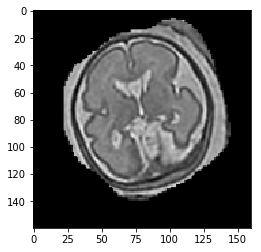

In [43]:
# view created dicoms
iFileToTest = 50
dcmTest = pyd.dcmread( os.path.join( dcmOutPath, r'IM_%04d'%(iFileToTest) ) )

print('dicom file:', r'IM_%04d'%(iFileToTest))
print('SpacingBetweenSlices =', dcmTest.SpacingBetweenSlices)
print('InstanceNumber =', dcmTest.InstanceNumber)
print('SliceLocation =', dcmTest.SliceLocation)
print('SeriesInstanceUID =', dcmTest.SeriesInstanceUID)
print('SOPInstanceUID =', dcmTest.SOPInstanceUID)
print('SeriesNumber =', dcmTest.SeriesNumber)
print('')

iFileToTest = iFileToTest + 1
dcmTest = pyd.dcmread( os.path.join( dcmOutPath, r'IM_%04d'%(iFileToTest) ) )

print('dicom file:', r'IM_%04d'%(iFileToTest))
print('SpacingBetweenSlices =', dcmTest.SpacingBetweenSlices)
print('InstanceNumber =', dcmTest.InstanceNumber)
print('SliceLocation =', dcmTest.SliceLocation)
print('SeriesInstanceUID =', dcmTest.SeriesInstanceUID)
print('SOPInstanceUID =', dcmTest.SOPInstanceUID)
print('SeriesNumber =', dcmTest.SeriesNumber)
print('')

print('nii details:')
print('shape:', nii_img.shape)
print('')

plt.imshow(nii_img[:,:,iFileToTest-1],  cmap=plt.cm.gray) # -1 to match counting of filenames

(160, 160)
160 160


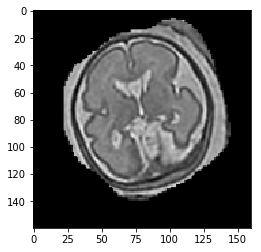

In [44]:
print(dcmTest.pixel_array.shape)
print(dcmTest.Rows, dcmTest.Columns)
plt.imshow(dcmTest.pixel_array,  cmap=plt.cm.gray)

In [45]:
dcmTest

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 192
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.25.317299940777100340965580508843853094229
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.46.670589.11.0.0.51.4.56.1
(0002, 0013) Implementation Version Name         SH: 'RESEARCH_SVR_DICOM'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M_SE', 'M', 'SE']
(0008, 0012) Instance Creation Date              DA: '20201109'
(0008, 0013) Instance Creation Time              TM: '091124.555'
(0008, 0014) Instance Creator UID                UI: 1.3.46.670589.11.741792261.3